# Introduction

Our project focuses on predicting strokes within humans. The dataset is extensive, containing over 5100 examples and including features such as gender, age, hypertenstion, heart disease, marriage, job occupation, residence type, glucose levels, bmi, and smoking status. These features will be used to make a binary prediction of whether that person has had a stroke or not. This is very interesting as our analysis describes what factors contribute most and least to strokes. This information can be informative regarding medical and health practices.

# Setup

In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

import torch

In [410]:
# Initialize DataFrame
df = pd.read_csv('healthcare-dataset-stroke-data.csv').drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Initial Analysis

In [411]:
# Dataset Overview
print("Dataset Shape:", df.shape)

print("\nColumn Data Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nMissing BMI: {df['bmi'].isnull().sum()} ({df['bmi'].isnull().sum()/len(df)*100:.2f}%)")

Dataset Shape: (5110, 11)

Column Data Types:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Basic Statistics:
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.0

Stroke Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Stroke Percentage:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


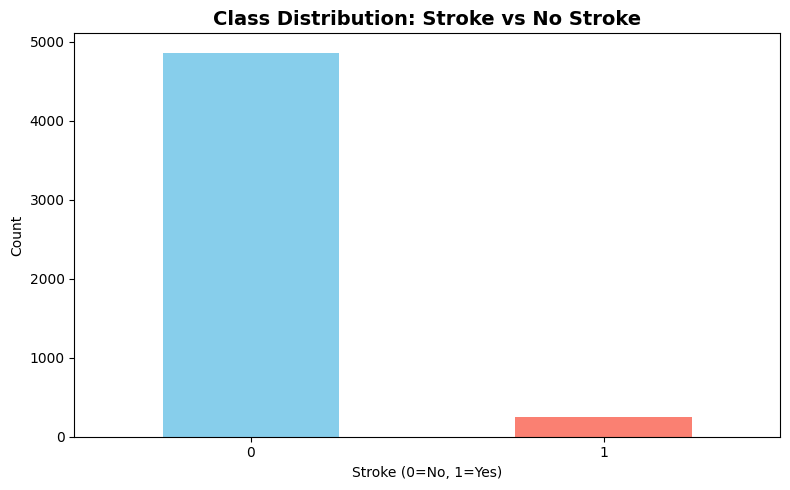

In [412]:
# Check class balance (Target variable)
print("Stroke Distribution:")
print(df['stroke'].value_counts())
print("\nStroke Percentage:")
print(df['stroke'].value_counts(normalize=True) * 100)

# Visualize class balance
plt.figure(figsize=(8, 5))
df['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Stroke vs No Stroke', fontsize=14, fontweight='bold')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

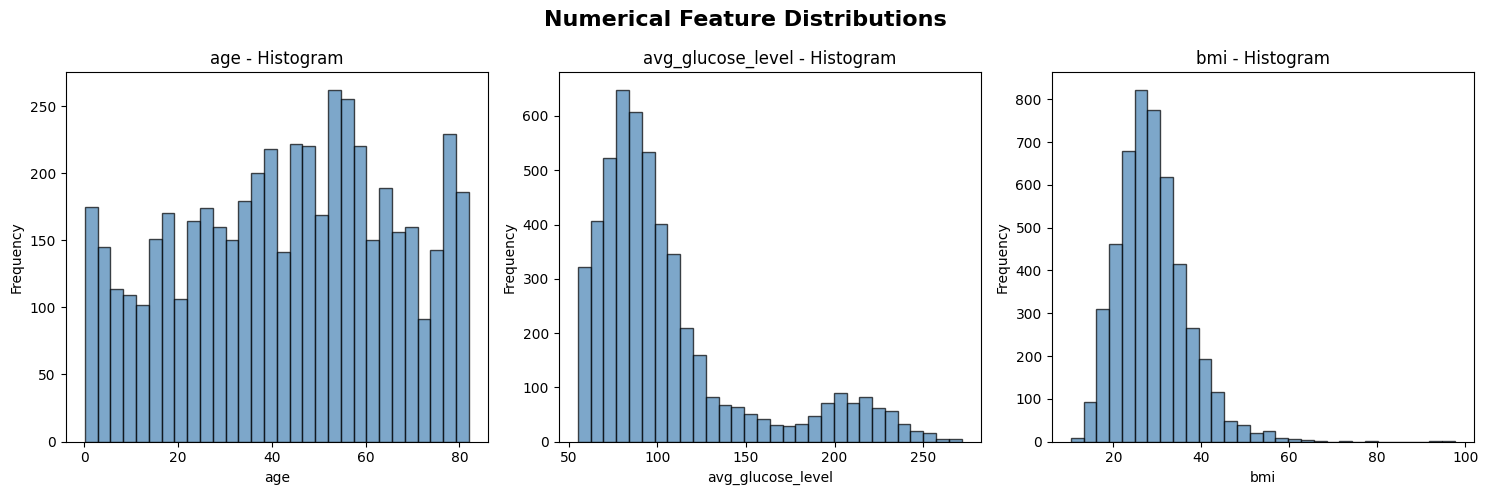

In [413]:
# Numerical Feature Distributions
numerical_features = ['age', 'avg_glucose_level', 'bmi']
num_features = len(numerical_features)
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
fig.suptitle('Numerical Feature Distributions', fontsize=16, fontweight='bold')

if num_features == 1:
    axes = [axes] 

for idx, feature in enumerate(numerical_features):
    axes[idx].hist(df[feature].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} - Histogram')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



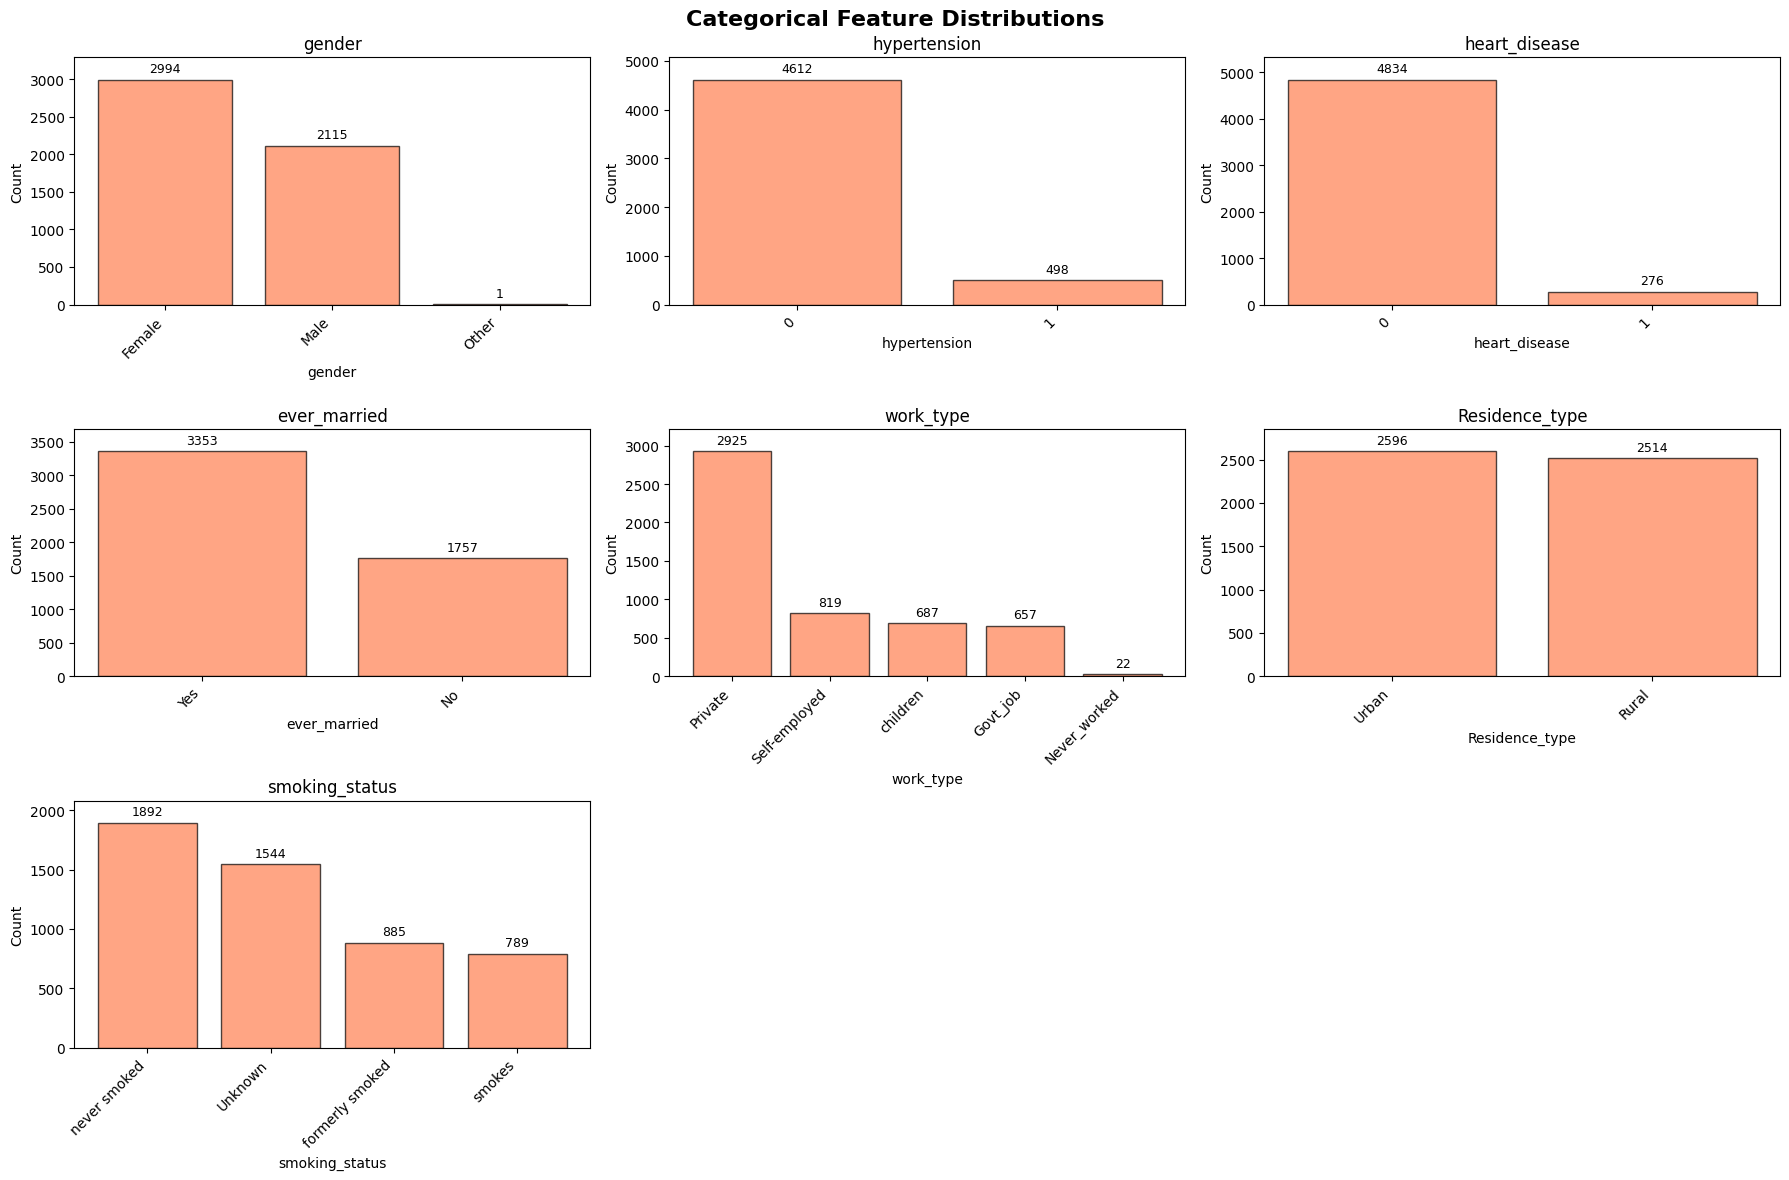

In [414]:
# Categorical Feature Distributions
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    counts = df[feature].value_counts()
    axes[idx].bar(range(len(counts)), counts.values, color='coral', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    max_val = max(counts.values)
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v + max_val * 0.02, str(v), ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_val * 1.1)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


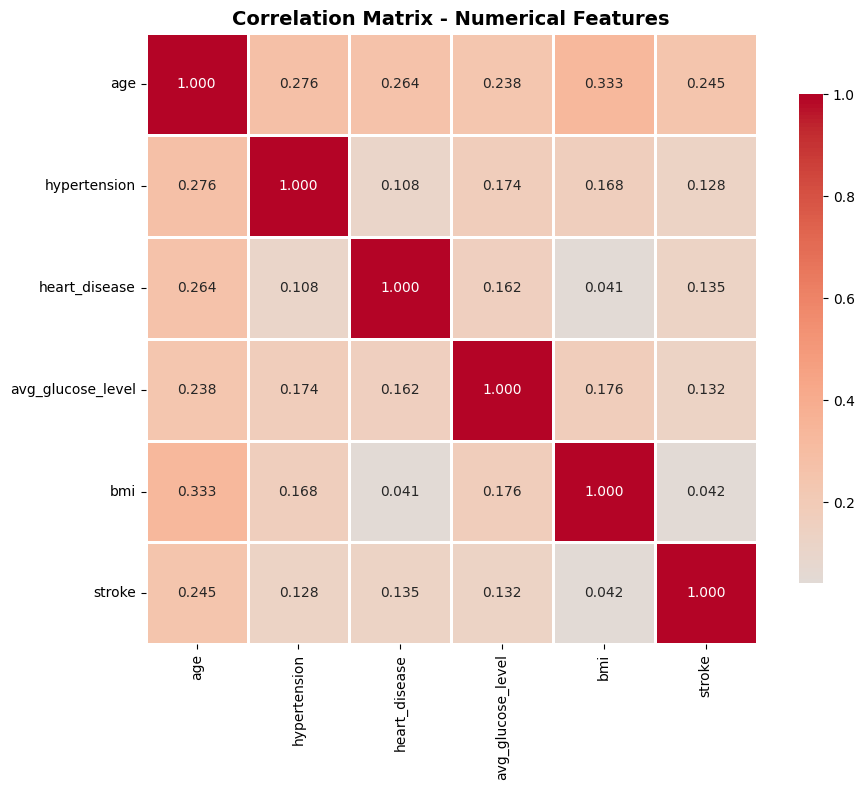


Correlations with Stroke (Target):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64


In [415]:
# Correlation Matrix for Numerical Features
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelations with Stroke (Target):")
print(correlation_matrix['stroke'].sort_values(ascending=False))


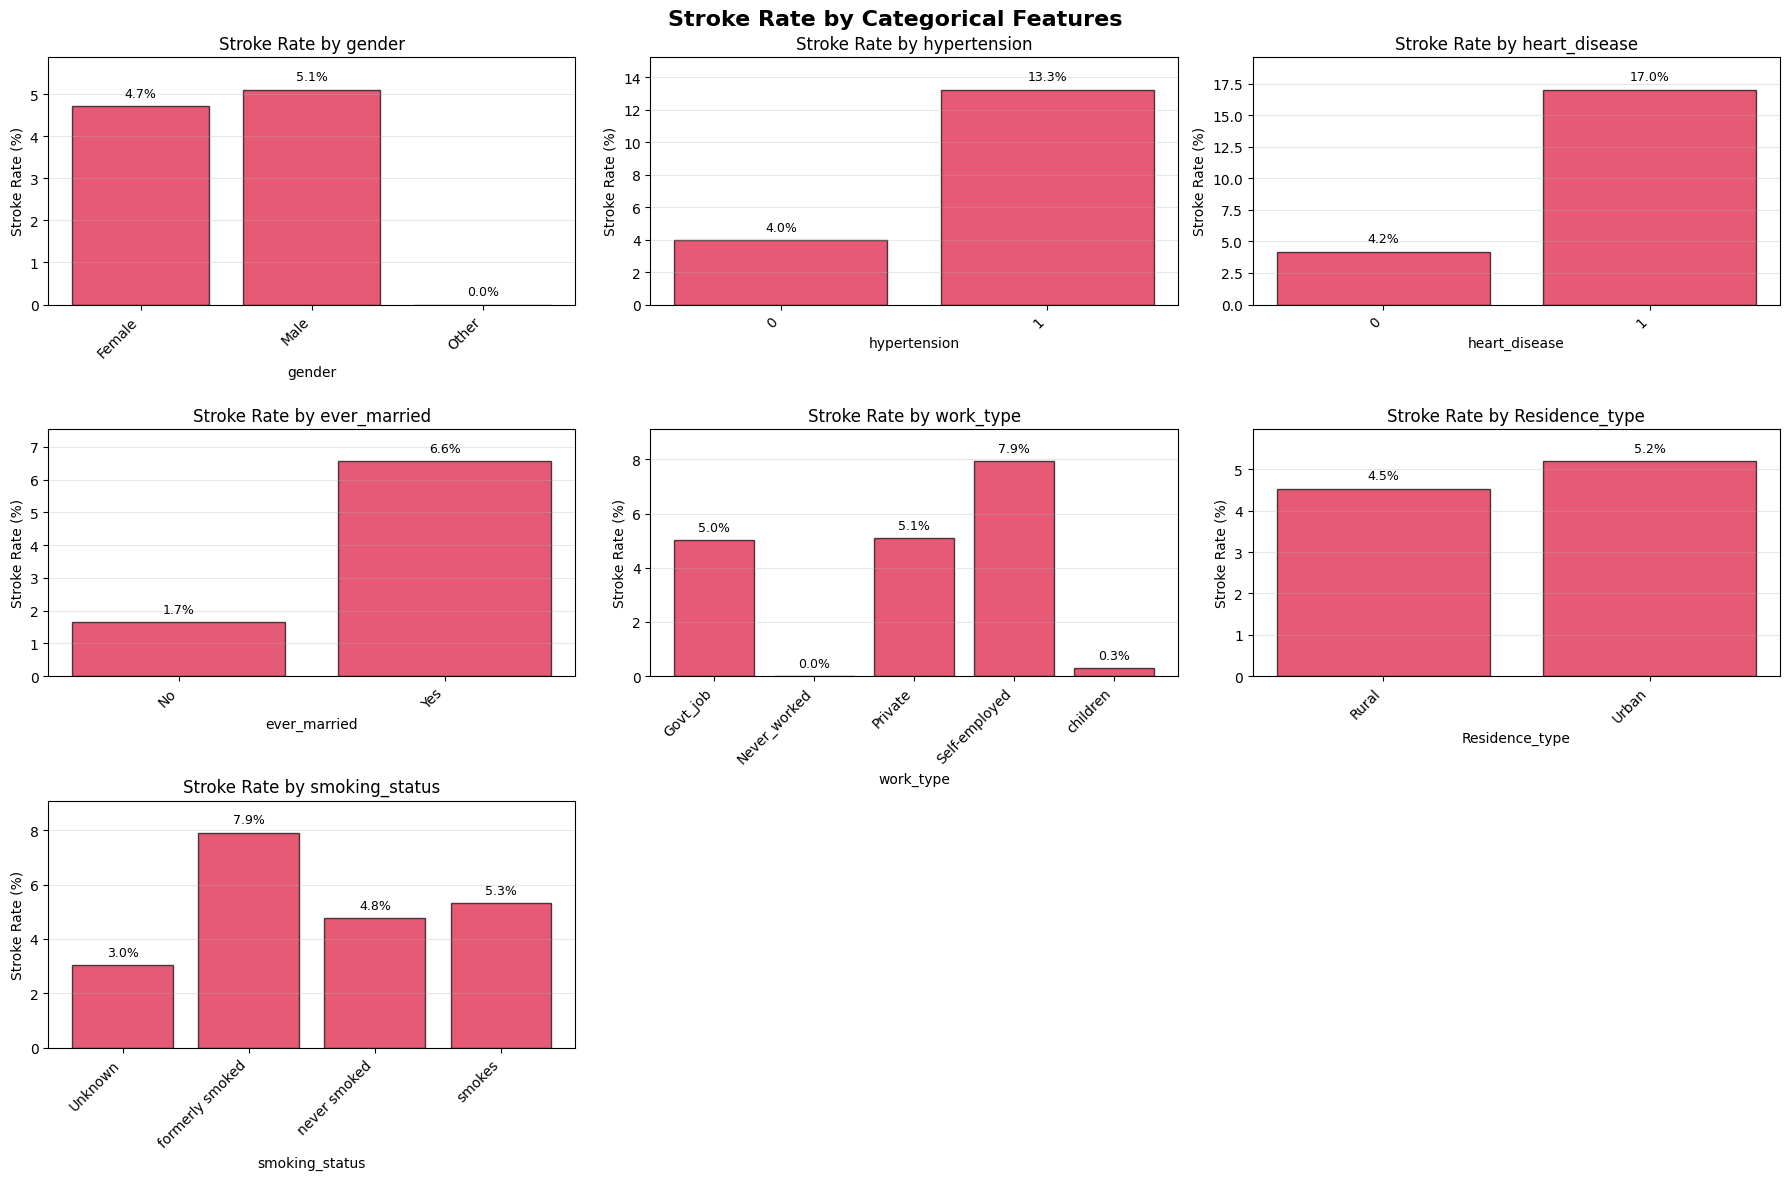

In [416]:
# Categorical Features vs Stroke 
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Stroke Rate by Categorical Features', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    # Calculate stroke rate for each category
    stroke_rate = df.groupby(feature)['stroke'].agg(['sum', 'count', 'mean'])
    stroke_rate['percentage'] = stroke_rate['mean'] * 100
    
    # Create grouped bar chart
    x = range(len(stroke_rate))
    axes[idx].bar(x, stroke_rate['percentage'], color='crimson', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Stroke Rate by {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Stroke Rate (%)')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(stroke_rate.index, rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    max_pct = stroke_rate['percentage'].max()
    for i, v in enumerate(stroke_rate['percentage']):
        axes[idx].text(i, v + max_pct * 0.03, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_pct * 1.15)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [417]:
# Key Observations from Initial EDA
print("KEY OBSERVATIONS FROM INITIAL ANALYSIS")

print("\n1. CLASS IMBALANCE:")
print(f"   - No Stroke: {(df['stroke']==0).sum()} ({(df['stroke']==0).sum()/len(df)*100:.1f}%)")
print(f"   - Stroke: {(df['stroke']==1).sum()} ({(df['stroke']==1).sum()/len(df)*100:.1f}%)")
print("   Highly imbalanced dataset")

print("\n2. MISSING DATA:")
print(f"   - BMI has {(df['bmi'].isna().sum()/len(df)*100):.2f}% missing values (before imputation)")
print("   - All other features are complete")

print("\n3. STRONGEST CORRELATIONS WITH STROKE:")
corr_with_stroke = correlation_matrix['stroke'].drop('stroke').sort_values(ascending=False)
for feature, corr_value in corr_with_stroke.head(3).items():
    print(f"   - {feature}: {corr_value:.3f}")

print("\n4. NUMERICAL FEATURE DISTRIBUTIONS:")
print("   - Age: Right-skewed, most patients between 40-80")
print("   - Glucose: Right-skewed with some high outliers")
print("   - BMI: Approximately normal distribution")

print("\n5. CATEGORICAL FEATURE DISTRIBUTIONS:")
print(f"   - Gender: {df['gender'].value_counts()['Female']} Female ({df['gender'].value_counts()['Female']/len(df)*100:.1f}%), " +
      f"{df['gender'].value_counts()['Male']} Male ({df['gender'].value_counts()['Male']/len(df)*100:.1f}%)")
print(f"   - Hypertension: {(df['hypertension']==1).sum()} patients ({(df['hypertension']==1).sum()/len(df)*100:.1f}%) have hypertension")
print(f"   - Heart Disease: {(df['heart_disease']==1).sum()} patients ({(df['heart_disease']==1).sum()/len(df)*100:.1f}%) have heart disease")
print(f"   - Marriage: {(df['ever_married']=='Yes').sum()} patients ({(df['ever_married']=='Yes').sum()/len(df)*100:.1f}%) are married")
print(f"   - Work Type: Private sector dominates ({df['work_type'].value_counts()['Private']} patients, {df['work_type'].value_counts()['Private']/len(df)*100:.1f}%)")
print(f"   - Residence: {(df['Residence_type']=='Urban').sum()} Urban ({(df['Residence_type']=='Urban').sum()/len(df)*100:.1f}%), " +
      f"{(df['Residence_type']=='Rural').sum()} Rural ({(df['Residence_type']=='Rural').sum()/len(df)*100:.1f}%)")
smoking_counts = df['smoking_status'].value_counts()
print(f"   - Smoking Status: {smoking_counts['never smoked']} never smoked ({smoking_counts['never smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['formerly smoked']} formerly smoked ({smoking_counts['formerly smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['smokes']} smokes ({smoking_counts['smokes']/len(df)*100:.1f}%), " +
      f"{smoking_counts['Unknown']} unknown ({smoking_counts['Unknown']/len(df)*100:.1f}%)")

print("\n6. STROKE RISK BY CATEGORY (Key Risk Factors):")
hyp_stroke_rate = df[df['hypertension']==1]['stroke'].mean() * 100
no_hyp_stroke_rate = df[df['hypertension']==0]['stroke'].mean() * 100
heart_stroke_rate = df[df['heart_disease']==1]['stroke'].mean() * 100
no_heart_stroke_rate = df[df['heart_disease']==0]['stroke'].mean() * 100
married_stroke_rate = df[df['ever_married']=='Yes']['stroke'].mean() * 100
not_married_stroke_rate = df[df['ever_married']=='No']['stroke'].mean() * 100

print(f"   - Hypertension: {hyp_stroke_rate:.1f}% stroke rate (vs {no_hyp_stroke_rate:.1f}% without)")
print(f"   - Heart Disease: {heart_stroke_rate:.1f}% stroke rate (vs {no_heart_stroke_rate:.1f}% without)")
print(f"   - Ever Married: {married_stroke_rate:.1f}% stroke rate (vs {not_married_stroke_rate:.1f}% not married)")
print(f"   - Gender: Similar rates between Male ({df[df['gender']=='Male']['stroke'].mean()*100:.1f}%) " +
      f"and Female ({df[df['gender']=='Female']['stroke'].mean()*100:.1f}%)")
print(f"   - Smoking: formerly smoked ({df[df['smoking_status']=='formerly smoked']['stroke'].mean()*100:.1f}%), " +
      f"never smoked ({df[df['smoking_status']=='never smoked']['stroke'].mean()*100:.1f}%), " +
      f"smokes ({df[df['smoking_status']=='smokes']['stroke'].mean()*100:.1f}%), " +
      f"unknown ({df[df['smoking_status']=='Unknown']['stroke'].mean()*100:.1f}%)")

KEY OBSERVATIONS FROM INITIAL ANALYSIS

1. CLASS IMBALANCE:
   - No Stroke: 4861 (95.1%)
   - Stroke: 249 (4.9%)
   Highly imbalanced dataset

2. MISSING DATA:
   - BMI has 3.93% missing values (before imputation)
   - All other features are complete

3. STRONGEST CORRELATIONS WITH STROKE:
   - age: 0.245
   - heart_disease: 0.135
   - avg_glucose_level: 0.132

4. NUMERICAL FEATURE DISTRIBUTIONS:
   - Age: Right-skewed, most patients between 40-80
   - Glucose: Right-skewed with some high outliers
   - BMI: Approximately normal distribution

5. CATEGORICAL FEATURE DISTRIBUTIONS:
   - Gender: 2994 Female (58.6%), 2115 Male (41.4%)
   - Hypertension: 498 patients (9.7%) have hypertension
   - Heart Disease: 276 patients (5.4%) have heart disease
   - Marriage: 3353 patients (65.6%) are married
   - Work Type: Private sector dominates (2925 patients, 57.2%)
   - Residence: 2596 Urban (50.8%), 2514 Rural (49.2%)
   - Smoking Status: 1892 never smoked (37.0%), 885 formerly smoked (17.3%), 7

# Preprocessing

### Imputing Null Values

In [418]:
# KNN Imputation for null bmi values
imputer = KNNImputer(n_neighbors=5)
df[['bmi']] = imputer.fit_transform(df[['bmi']])

# Verify
null_percentage = df.isnull().mean() * 100
print(null_percentage)

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64


### Encoding Categorical Data

In [419]:
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int)
df['Residence_type'] = (df['Residence_type'] == 'Urban').astype(int)

df_encoded = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True, dtype=int)

# Verify
df_encoded.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.600000,1,1,0,0,1,0,0,1,0,0
1,61.0,0,0,1,0,202.21,28.893237,1,0,0,0,0,1,0,0,1,0
2,80.0,0,1,1,0,105.92,32.500000,1,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.400000,1,0,0,0,1,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,0,1,0,0,1,0
5,81.0,0,0,1,1,186.21,29.000000,1,1,0,0,1,0,0,1,0,0
6,74.0,1,1,1,0,70.09,27.400000,1,1,0,0,1,0,0,0,1,0
7,69.0,0,0,0,1,94.39,22.800000,1,0,0,0,1,0,0,0,1,0
8,59.0,0,0,1,0,76.15,28.893237,1,0,0,0,1,0,0,0,0,0
9,78.0,0,0,1,1,58.57,24.200000,1,0,0,0,1,0,0,0,0,0


### Train-Validation-Test Split

In [420]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} ({y_train.mean()*100:.2f}% stroke)")
print(f"Val: {X_val.shape[0]} ({y_val.mean()*100:.2f}% stroke)")
print(f"Test: {X_test.shape[0]} ({y_test.mean()*100:.2f}% stroke)")

Train: 3066 (4.86% stroke)
Val: 1022 (4.89% stroke)
Test: 1022 (4.89% stroke)


### Standard Scaling


In [421]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Verify
X_train_scaled.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1990,-1.827461,0,0,0,1,0.134857,-1.348876,1,0,0,0,0,1,0,0,0
3840,-1.297185,0,0,0,1,-0.809394,-0.611890,0,0,0,1,0,0,1,0,0
2596,0.691353,0,0,1,0,-0.602963,0.125095,0,0,0,1,0,0,0,0,0
591,0.205266,0,0,1,1,-0.463883,0.404642,1,0,0,1,0,0,0,0,1
2975,-0.457580,0,0,1,0,0.161973,1.815080,0,0,0,1,0,0,0,1,0
2170,1.486768,0,0,1,0,-0.566443,-1.221809,0,0,0,1,0,0,0,0,0
2383,0.514594,0,0,1,0,2.756586,-0.027384,1,0,0,1,0,0,0,0,0
3230,0.072697,0,0,1,1,-0.452512,1.154334,0,0,0,1,0,0,0,1,0
4565,0.558783,0,0,1,1,-0.188349,0.468175,0,0,0,0,1,0,1,0,0
4062,1.133250,0,0,1,1,-0.330271,-0.421290,0,0,0,1,0,0,1,0,0


# Exploratory & Unsupervised Analysis

### K-Means Clustering

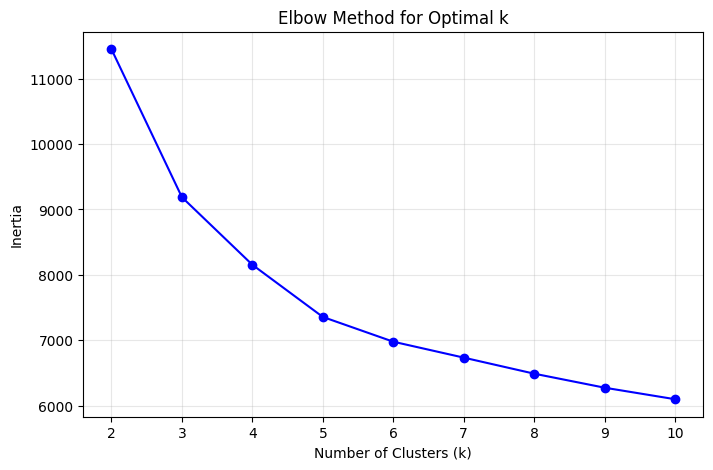

In [422]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_train_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [423]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

print("Cluster vs Stroke:")
print(pd.crosstab(clusters, y_train))

Cluster vs Stroke:
stroke     0   1
row_0           
0        855   2
1        371  57
2       1691  90


### PCA Visualization

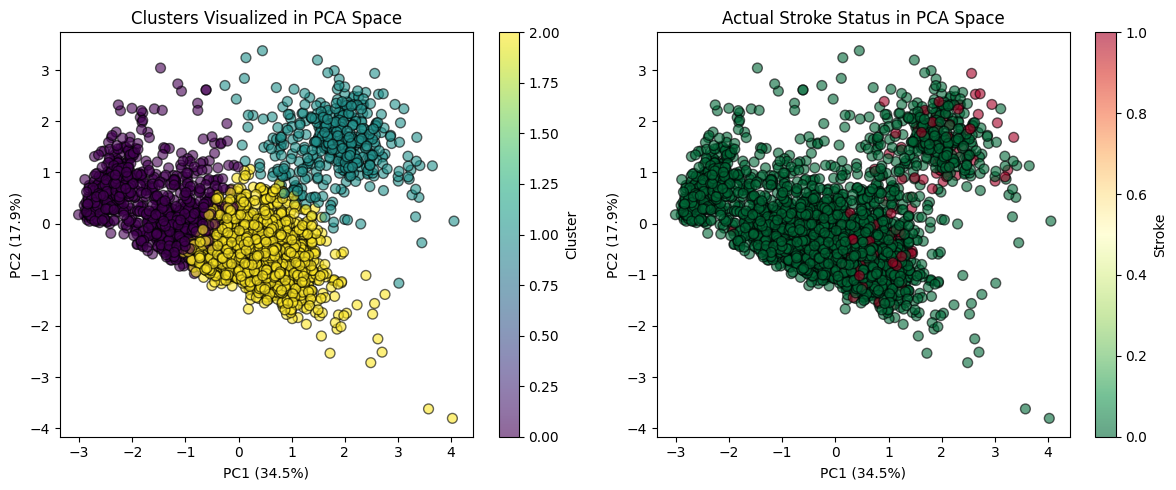

PC1 explains 34.46% of variance
PC2 explains 17.89% of variance
Total: 52.35%


In [424]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Clusters Visualized in PCA Space')
plt.colorbar(scatter, label='Cluster')

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='RdYlGn_r', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Actual Stroke Status in PCA Space')
plt.colorbar(scatter, label='Stroke')

plt.tight_layout()
plt.show()

print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

In [425]:
cluster_df = X_train_scaled.copy()
cluster_df['cluster'] = clusters
cluster_df['stroke'] = y_train.values

print("Cluster Characteristics (mean values):")
print(cluster_df.groupby('cluster')[numerical_cols].mean())
print("\nStroke rate by cluster:")
print(cluster_df.groupby('cluster')['stroke'].mean() * 100)


Cluster Characteristics (mean values):
              age  avg_glucose_level       bmi
cluster                                       
0       -1.235251          -0.285628 -0.843093
1        0.783759           2.154037  0.552942
2        0.406042          -0.380205  0.272808

Stroke rate by cluster:
cluster
0     0.233372
1    13.317757
2     5.053341
Name: stroke, dtype: float64


### Conlusion

During the unsupervised analysis, K-means identified three main clusters. While cluster one and cluster two had the most cases where there was a stroke (13.30% and 5.05% respectively), the majority of the strokes were still scattered throughout the data. However, cluster zero was extremely safe, containing only two cases where there was a stroke. Overall, the structure is moderate and the clusters do not separate strokes very well, suggesting missing relationships. Because of this, we will add feature additions and/or transformations in the supervised section of this notebook.

# Supervised Modeling

### Logistic Regression

In [426]:
warnings.filterwarnings('ignore')

# Testing different regularization strengths
# Smaller C = more regularization (simpler model), larger C = less regularization (more complex)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results_lr = []

#### Baseline: Untransformed Data

**Rationale**: Establish a baseline using original scaled features without transformations. This allows us to see if feature engineering improves results.


In [427]:

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_scaled, y_train)
    
    train_pred = lr.predict(X_train_scaled)
    val_pred = lr.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Baseline',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    overfit_gap = train_acc - val_acc
    if overfit_gap > 0.05:
        reason = " (Overfitting - large train/val gap)"
    elif train_acc < 0.7 and val_acc < 0.7:
        reason = " (Underfitting - both low)"
    else:
        reason = ""
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}{reason}")

baseline_results = [r for r in results_lr if r['transformation'] == 'Baseline']
best_baseline = max(baseline_results, key=lambda x: x['val_f1'])
print(f"\nBest baseline: C={best_baseline['C']} with F1={best_baseline['val_f1']:.4f}")
gap = best_baseline['train_acc'] - best_baseline['val_acc']
if gap > 0.05:
    print(f"  - Overfitting (train {gap:.3f} higher than val) - will try stronger regularization")
elif best_baseline['train_acc'] < 0.75:
    print("  - Underfitting - will try adding features to capture more patterns")


C= 0.001: Train Acc=0.7179, Val Acc=0.7290, Val Prec=0.1350, Val Rec=0.8400, Val F1=0.2327
C= 0.010: Train Acc=0.7283, Val Acc=0.7329, Val Prec=0.1344, Val Rec=0.8200, Val F1=0.2310
C= 0.100: Train Acc=0.7397, Val Acc=0.7476, Val Prec=0.1414, Val Rec=0.8200, Val F1=0.2412
C= 1.000: Train Acc=0.7417, Val Acc=0.7573, Val Prec=0.1464, Val Rec=0.8200, Val F1=0.2485
C=10.000: Train Acc=0.7410, Val Acc=0.7593, Val Prec=0.1475, Val Rec=0.8200, Val F1=0.2500
C=100.000: Train Acc=0.7404, Val Acc=0.7593, Val Prec=0.1475, Val Rec=0.8200, Val F1=0.2500

Best baseline: C=10 with F1=0.2500
  - Underfitting - will try adding features to capture more patterns


#### Transformation 1: Polynomial Features (Degree 2)

**Why**: Clusters didn't separate stroke well, so maybe we need non-linear relationships. Polynomial features create combinations like age² and age×glucose. This adds lots of features, so might need stronger regularization to avoid overfitting.


In [428]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]} ({(X_train_poly.shape[1]/X_train_scaled.shape[1]):.1f}x more)")
print("Expecting lower C values to work better since we have more features now.\n")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_poly, y_train)
    
    train_pred = lr.predict(X_train_poly)
    val_pred = lr.predict(X_val_poly)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Polynomial (deg=2)',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

poly_results = [r for r in results_lr if r['transformation'] == 'Polynomial (deg=2)']
best_poly = max(poly_results, key=lambda x: x['val_f1'])
print(f"\nBest polynomial: C={best_poly['C']} with F1={best_poly['val_f1']:.4f}")
gap = best_poly['train_acc'] - best_poly['val_acc']
if gap > 0.1:
    print(f"  - Bad overfitting (gap={gap:.3f}) - too many features, need stronger regularization")
elif best_poly['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_poly['val_f1']:.4f})")
    print("  - Polynomial features are helping")
else:
    print("  - No improvement - polynomial features might just be adding noise")


Original features: 16
Polynomial features: 152 (9.5x more)
Expecting lower C values to work better since we have more features now.

C= 0.001: Train Acc=0.7560, Val Acc=0.7701, Val Prec=0.1509, Val Rec=0.8000, Val F1=0.2540
C= 0.010: Train Acc=0.7538, Val Acc=0.7573, Val Prec=0.1387, Val Rec=0.7600, Val F1=0.2346
C= 0.100: Train Acc=0.7547, Val Acc=0.7564, Val Prec=0.1328, Val Rec=0.7200, Val F1=0.2243
C= 1.000: Train Acc=0.7609, Val Acc=0.7554, Val Prec=0.1269, Val Rec=0.6800, Val F1=0.2138
C=10.000: Train Acc=0.7590, Val Acc=0.7515, Val Prec=0.1222, Val Rec=0.6600, Val F1=0.2062
C=100.000: Train Acc=0.7564, Val Acc=0.7456, Val Prec=0.1140, Val Rec=0.6200, Val F1=0.1925

Best polynomial: C=0.001 with F1=0.2540
  - Better than baseline! (F1: 0.2500 -> 0.2540)
  - Polynomial features are helping


#### Transformation 2: PCA Components

**Why**: PCA reduces features by keeping the important parts (85% of variance). This removes noise and might help if we're overfitting. With fewer features, we might need less regularization.


In [429]:
pca_lr = PCA(n_components=0.85)
X_train_pca = pca_lr.fit_transform(X_train_scaled)
X_val_pca = pca_lr.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]} (removed {X_train_scaled.shape[1] - X_train_pca.shape[1]} features)")
print(f"Kept {sum(pca_lr.explained_variance_ratio_)*100:.1f}% of variance")
print("Fewer features, so might need less regularization.\n")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_pca, y_train)
    
    train_pred = lr.predict(X_train_pca)
    val_pred = lr.predict(X_val_pca)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'PCA (85% var)',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

pca_results = [r for r in results_lr if r['transformation'] == 'PCA (85% var)']
best_pca = max(pca_results, key=lambda x: x['val_f1'])
print(f"\nBest PCA: C={best_pca['C']} with F1={best_pca['val_f1']:.4f}")
gap = best_pca['train_acc'] - best_pca['val_acc']

if best_pca['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_pca['val_f1']:.4f})")
    if gap < 0.03:
        print("  - Also reduced overfitting - PCA worked well")
else:
    print(f"  - F1 didn't improve (baseline: {best_baseline['val_f1']:.4f})")
    if gap < 0.03:
        print("  - But PCA did reduce overfitting - probably removed signal along with noise")
    else:
        print("  - Didn't help with overfitting either - removed important features")


Original features: 16
PCA components: 7 (removed 9 features)
Kept 88.7% of variance
Fewer features, so might need less regularization.

C= 0.001: Train Acc=0.7100, Val Acc=0.7182, Val Prec=0.1281, Val Rec=0.8200, Val F1=0.2216
C= 0.010: Train Acc=0.7162, Val Acc=0.7309, Val Prec=0.1359, Val Rec=0.8400, Val F1=0.2340
C= 0.100: Train Acc=0.7221, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C= 1.000: Train Acc=0.7241, Val Acc=0.7348, Val Prec=0.1353, Val Rec=0.8200, Val F1=0.2323
C=10.000: Train Acc=0.7244, Val Acc=0.7358, Val Prec=0.1358, Val Rec=0.8200, Val F1=0.2330
C=100.000: Train Acc=0.7244, Val Acc=0.7358, Val Prec=0.1358, Val Rec=0.8200, Val F1=0.2330

Best PCA: C=0.01 with F1=0.2340
  - F1 didn't improve (baseline: 0.2500)
  - But PCA did reduce overfitting - probably removed signal along with noise


#### Transformation 3: Interaction Terms

**Why**: Medical knowledge says some combinations matter, like age×glucose or hypertension×heart_disease. Adding just these specific interactions instead of all polynomial terms. More targeted than polynomial features.


In [430]:
print("Only 5 new features (vs 100+ from polynomial).\n")

X_train_interact = X_train_scaled.copy()
X_val_interact = X_val_scaled.copy()

X_train_interact['age_glucose'] = X_train_scaled['age'] * X_train_scaled['avg_glucose_level']
X_train_interact['age_bmi'] = X_train_scaled['age'] * X_train_scaled['bmi']
X_train_interact['glucose_bmi'] = X_train_scaled['avg_glucose_level'] * X_train_scaled['bmi']
X_train_interact['hypertension_heart'] = X_train_scaled['hypertension'] * X_train_scaled['heart_disease']
X_train_interact['age_hypertension'] = X_train_scaled['age'] * X_train_scaled['hypertension']

X_val_interact['age_glucose'] = X_val_scaled['age'] * X_val_scaled['avg_glucose_level']
X_val_interact['age_bmi'] = X_val_scaled['age'] * X_val_scaled['bmi']
X_val_interact['glucose_bmi'] = X_val_scaled['avg_glucose_level'] * X_val_scaled['bmi']
X_val_interact['hypertension_heart'] = X_val_scaled['hypertension'] * X_val_scaled['heart_disease']
X_val_interact['age_hypertension'] = X_val_scaled['age'] * X_val_scaled['hypertension']

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"With interactions: {X_train_interact.shape[1]} (+5 features)")

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced')
    lr.fit(X_train_interact, y_train)
    
    train_pred = lr.predict(X_train_interact)
    val_pred = lr.predict(X_val_interact)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, zero_division=0)
    val_rec = recall_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred)
    
    results_lr.append({
        'transformation': 'Interactions',
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_precision': val_prec,
        'val_recall': val_rec,
        'val_f1': val_f1
    })
    
    print(f"C={C:6.3f}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val Prec={val_prec:.4f}, Val Rec={val_rec:.4f}, Val F1={val_f1:.4f}")

interact_results = [r for r in results_lr if r['transformation'] == 'Interactions']
best_interact = max(interact_results, key=lambda x: x['val_f1'])
print(f"\nBest interactions: C={best_interact['C']} with F1={best_interact['val_f1']:.4f}")
gap = best_interact['train_acc'] - best_interact['val_acc']
if gap > 0.05:
    print(f"  - Some overfitting (gap={gap:.3f}) - might need stronger regularization")
elif best_interact['val_f1'] > best_baseline['val_f1']:
    print(f"  - Better than baseline! (F1: {best_baseline['val_f1']:.4f} -> {best_interact['val_f1']:.4f})")
    print("  - These interactions are helping")
else:
    print("  - No improvement - interactions might not matter as much")

Only 5 new features (vs 100+ from polynomial).

Original features: 16
With interactions: 21 (+5 features)
C= 0.001: Train Acc=0.7427, Val Acc=0.7544, Val Prec=0.1423, Val Rec=0.8000, Val F1=0.2417
C= 0.010: Train Acc=0.7378, Val Acc=0.7397, Val Prec=0.1376, Val Rec=0.8200, Val F1=0.2356
C= 0.100: Train Acc=0.7391, Val Acc=0.7466, Val Prec=0.1409, Val Rec=0.8200, Val F1=0.2405
C= 1.000: Train Acc=0.7414, Val Acc=0.7476, Val Prec=0.1389, Val Rec=0.8000, Val F1=0.2367
C=10.000: Train Acc=0.7427, Val Acc=0.7495, Val Prec=0.1424, Val Rec=0.8200, Val F1=0.2426
C=100.000: Train Acc=0.7427, Val Acc=0.7495, Val Prec=0.1424, Val Rec=0.8200, Val F1=0.2426

Best interactions: C=10 with F1=0.2426
  - No improvement - interactions might not matter as much


#### Results Summary Table


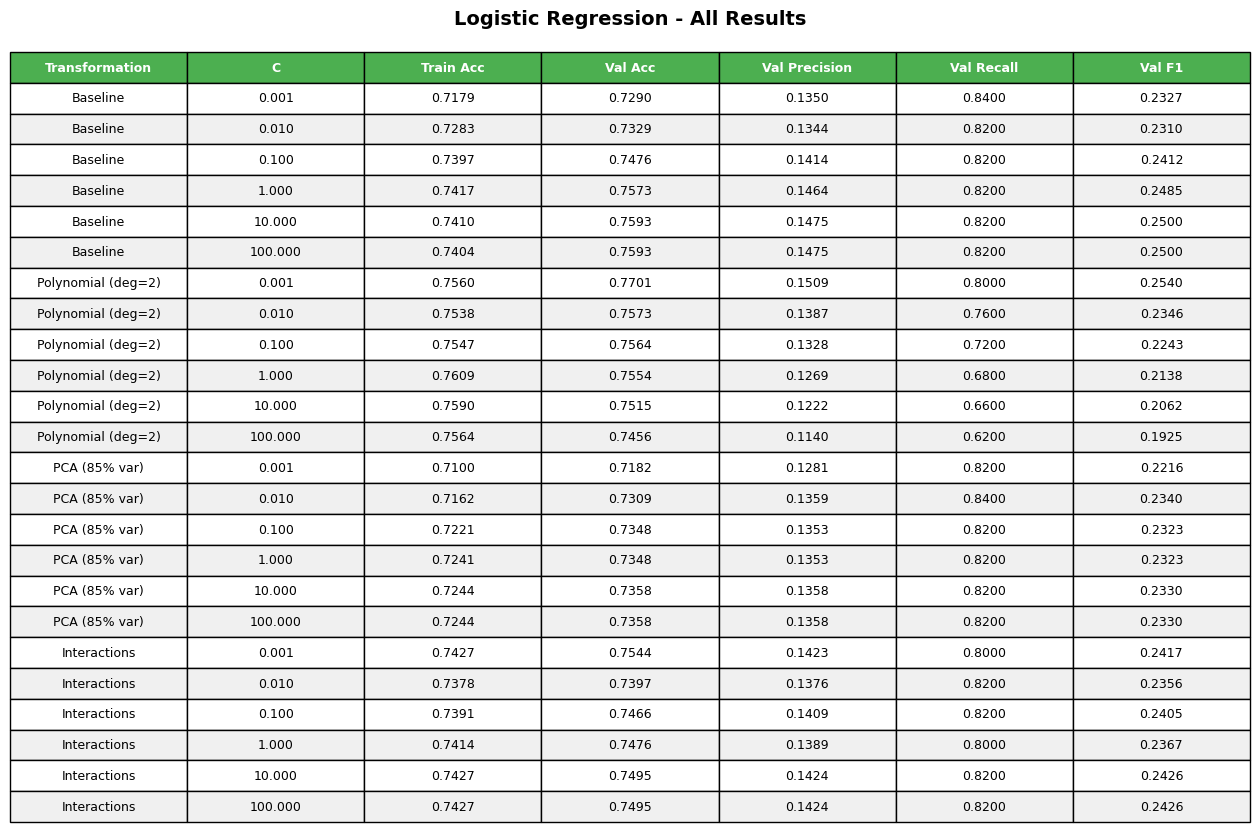


Best Model: Polynomial (deg=2) with C=0.001
  Train Acc: 0.7560, Val Acc: 0.7701
  Val Precision: 0.1509, Val Recall: 0.8000, Val F1: 0.2540


In [431]:
lr_results_df = pd.DataFrame(results_lr)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in lr_results_df.iterrows():
    table_data.append([
        row['transformation'],
        f"{row['C']:.3f}",
        f"{row['train_acc']:.4f}",
        f"{row['val_acc']:.4f}",
        f"{row['val_precision']:.4f}",
        f"{row['val_recall']:.4f}",
        f"{row['val_f1']:.4f}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Transformation', 'C', 'Train Acc', 'Val Acc', 'Val Precision', 'Val Recall', 'Val F1'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

for i in range(len(table_data) + 1):
    for j in range(7):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('white')

plt.title('Logistic Regression - All Results', fontsize=14, fontweight='bold', pad=20)
plt.show()

best_overall = lr_results_df.loc[lr_results_df['val_f1'].idxmax()]
print(f"\nBest Model: {best_overall['transformation']} with C={best_overall['C']:.3f}")
print(f"  Train Acc: {best_overall['train_acc']:.4f}, Val Acc: {best_overall['val_acc']:.4f}")
print(f"  Val Precision: {best_overall['val_precision']:.4f}, Val Recall: {best_overall['val_recall']:.4f}, Val F1: {best_overall['val_f1']:.4f}")

lr_best_model = best_overall
lr_all_metrics = lr_results_df


### Superviesed Method 2 (NN, KNN, CNN, etc)

### Superviesed Method 3 (NN, KNN, CNN, etc)

# Results